# 로지스틱 회귀

## #01. 작업준비

### 패키지 가져오기

In [1]:
from pandas import read_excel, DataFrame
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sb
from matplotlib import pyplot as plt
import numpy as np
import sys

### 그래프 초기화

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['axes.unicode_minus'] = False

### 데이터 가져오기

방사선학 석사과정 대학원생 모집을 하였다. 이 때 지원한 방사선사의 대학원 합격여부에 따른 주요 요인이 무엇인지 분석하라.

단, 독립변수는 정규 분포를 따른다고 가정하자.

|변수|구분|설명|
|---|---|---|
|합격여부|범주형|1=합격, 0=불합격|
|필기점수|연속형|800점만점|
|학부성적|연속형|4.0만점|
|병원경력|범주형|1:10년이상, 2:3~5년, 3:1~3년, 4:1년미만|

In [3]:
df = read_excel("https://data.hossam.kr/E05/gradeuate.xlsx")
df

,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
...,...,...,...,...
395,0,620,4.00,2
396,0,560,3.04,3
397,0,460,2.63,2
398,0,700,3.65,2


## #02. 기본분석

### 로지스틱 회귀수행

In [4]:
df1 = df.copy()
df1.head()

,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [5]:
model = logit('합격여부 ~ 필기점수+학부성적+병원경력', data=df1)
fit = model.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.574302
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   합격여부   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Mon, 31 Jul 2023   Pseudo R-squ.:                 0.08107
Time:                        14:20:01   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 8.207e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4495      1.133     -3.045      0.002      -5.670      -1.229
필기점수           0.0023      0.

### 로지스틱 회귀의 설명력 - 의사결정계수 ($Peseudo-R^2$)

종속변수의 분산 중 어느 정도 비율(%)이 독립변수에 의해 설명되는가를 나타내는 값

In [6]:
fit.prsquared

0.08107331586891464

### 예측 결과를 데이터프레임에 추가

In [7]:
df1['예측값'] = fit.predict(df1.drop('합격여부', axis=1))
df1['예측결과'] = df1['예측값'] > 0.5
df1

,합격여부,필기점수,학부성적,병원경력,예측값,예측결과
0,0,380,3.61,3,0.189553,False
1,1,660,3.67,3,0.317781,False
2,1,800,4.00,1,0.717814,True
3,1,640,3.19,4,0.148949,False
4,0,520,2.93,4,0.097954,False
...,...,...,...,...,...,...
395,0,620,4.00,2,0.490176,False
396,0,560,3.04,3,0.184989,False
397,0,460,2.63,2,0.186814,False
398,0,700,3.65,2,0.468108,False


### 혼동행렬 구하기

In [8]:
cm = confusion_matrix(df1['합격여부'], df1['예측결과'])
cm

array([[253,  20],
       [ 98,  29]], dtype=int64)

In [9]:
cm = confusion_matrix(df1['합격여부'], df1['예측결과'])
tn, fp, fn, tp = cm.ravel()

print(tn, fp, fn, tp)

cmdf = DataFrame([[tn, tp],[fn, fp]], index=['True', 'False'], columns=['Negative','Positive'])
cmdf

253 20 98 29


,Negative,Positive
True,253,29
False,98,20


### ROC Curve 시각화

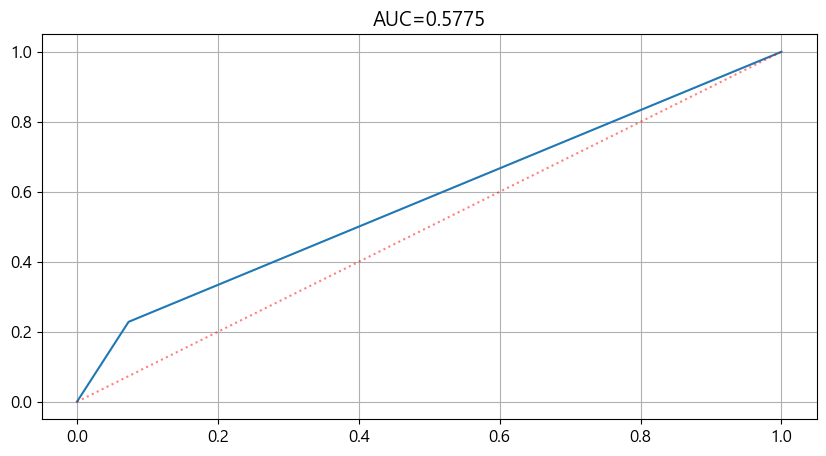

In [10]:
ras = roc_auc_score(df1['합격여부'], df1['예측결과'])

# 위양성율, 재현율, 임계값(사용안함)
fpr, tpr, thresholds = roc_curve(df1['합격여부'], df1['예측결과'])

plt.figure()
sb.lineplot(x=fpr, y=tpr)
sb.lineplot(x=[0,1], y=[0,1], color='red', linestyle=':', alpha=0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

In [11]:
# 정확도
acc = accuracy_score(df1['합격여부'], df1['예측결과'])

#정밀도
pre = precision_score(df1['합격여부'], df1['예측결과'])

#재현율
recall = recall_score(df1['합격여부'], df1['예측결과'])

#F1 score
f1 = f1_score(df1['합격여부'], df1['예측결과'])

#위양성율
fallout = fp / (fp+tn)

#특이성
spe = 1-fallout

result_df = DataFrame({'설명력(Pseudo-Rsqe)' : [fit.prsquared], '정확도(Accuracy)':[acc], '정밀도(Precision)':[pre], '재현율(Recall, TPR)':[recall], 'f1_score':[f1], '위양성율':[fallout], '특이성':[spe] })

result_df

,설명력(Pseudo-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)",f1_score,위양성율,특이성
0,0.081073,0.705,0.591837,0.228346,0.329545,0.07326,0.92674


### 오즈비(Odds Rate) 구하기

계수값들만 추출하기

- 독립변수의 `coef` : logit함수계수. 해당 독립함수의 오즈에 $log$를 씌운 값(자연로그)

In [12]:
coef = fit.params
coef

Intercept   -3.449549
필기점수         0.002294
학부성적         0.777014
병원경력        -0.560031
dtype: float64

### 오즈비 계산

오즈비는 성공하라 확률을 실패할 확률로 나눈 값이고 이 분석에서는 합격여부가 종속변수이므로 합격할 확률을 불합격할 확률로 나눈 값이다.

OddsRate = 불합격확률 / 합격확률

계수값에 대해 `np.exp()` 함수를 적용하면 각각의 회귀계수들을 오즈값으로 변환할 수 있다.

> 해당 독립변수가 종속변수에 미치는 영향을 더 직관적으로 확인할 수 있다. 학부성적이 종속변수인 합격여부에 끼치는 영향이 가장 크다고 볼 수 있다.




In [13]:
odds_rate = np.exp(coef)
odds_rate

Intercept    0.031760
필기점수         1.002297
학부성적         2.174967
병원경력         0.571191
dtype: float64

### 가상의 데이터를 통한 합격 여부 예측

In [14]:
myinput = input("필기점수, 학부성적, 병원경력을 콤마(,)로 구분하여 입력하세요.\n예: 480,4.3,2")

if not myinput:
    myinput = "480,4.3,2"

myinput = myinput.split(',')
mydata = {'필기점수': int(myinput[0].strip()), '학부성적': float(myinput[1].strip()), '병원경력': int(myinput[2].strip())}
myresult = fit.predict(mydata)
myresult


0    0.334615
dtype: float64

In [15]:
"당신의 합격 확률은 {0:0.2f}% 입니다.".format(myresult[0]*100)

'당신의 합격 확률은 33.46% 입니다.'